In [1]:
# Import tensorflow
import tensorflow as tf

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

In [24]:
# Import all remaining packages
import math
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
import os
# !pip install mitdeeplearning
import mitdeeplearning as mdl
from tqdm import tqdm

import livelossplot

%matplotlib inline

In [29]:
# Constants
INTERVAL_TIME = 3
SAMPLE_TIME = 20
INTERVAL_OVERLAP = 0.5
TIMESTEP_COUNT = math.ceil((SAMPLE_TIME - INTERVAL_TIME) / (INTERVAL_TIME * INTERVAL_OVERLAP))

SAMPLE_RATE = 256

FEATURES = 20
FEATURE_LIST = [
    "Delta_TP9", "Delta_AF7", "Delta_AF8", "Delta_TP10", 
    "Theta_TP9", "Theta_AF7", "Theta_AF8", "Theta_TP10", 
    "Alpha_TP9", "Alpha_AF7", "Alpha_AF8", "Alpha_TP10", 
    "Beta_TP9", "Beta_AF7", "Beta_AF8", "Beta_TP10", 
    "Gamma_TP9", "Gamma_AF7", "Gamma_AF8", "Gamma_TP10",
]

BATCH_SIZE = 16
EPOCHS = 5
NUM_CLASSES = 3

LEFT_DS_LOCATIONS = [
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Left\\museMonitor_2022-11-23--20-20-39_1374846198655688552.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Left\\museMonitor_2022-11-23--20-21-16_6403773277566742356.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Left\\museMonitor_2022-11-23--20-21-16_6403773277566742356.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Left\\museMonitor_2022-11-23--20-22-25_9040452647012648168.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Left\\museMonitor_2022-11-23--20-22-25_9040452647012648168.csv",
]
MIDDLE_DS_LOCATIONS = [
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Middle\\museMonitor_2022-11-23--20-24-31_3241552230625887354.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Middle\\museMonitor_2022-11-23--20-25-28_1419560302216719579.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Middle\\museMonitor_2022-11-23--20-26-00_5339249621360379372.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Middle\\museMonitor_2022-11-23--20-26-31_9151412776081488788.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Middle\\museMonitor_2022-11-23--20-27-05_8455441510607239183.csv",
]
RIGHT_DS_LOCATIONS = [
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Right\\museMonitor_2022-11-23--20-10-51_4392798336885910834.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Right\\museMonitor_2022-11-23--20-10-51_4392798336885910834.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Right\\museMonitor_2022-11-23--20-14-59_8872411055468760272.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Right\\museMonitor_2022-11-23--20-15-43_5478785789981537327.csv",
    "C:\\Users\\Chanakya\\BDR 2022\\Dataset\\Right\\museMonitor_2022-11-23--20-16-22_6405799957103154682.csv",
]

DS_COUNT = len(LEFT_DS_LOCATIONS) + len(MIDDLE_DS_LOCATIONS) + len(RIGHT_DS_LOCATIONS)

ZERO = 0.00000001
LEFT = 0
MIDDLE = 1
RIGHT = 2

In [30]:
# Accessing dataset
# Calculating possible starting points for the samples to be taken from dataset
starting_points = [i * INTERVAL_TIME * INTERVAL_OVERLAP for i in range(TIMESTEP_COUNT)]

# all_inputs dimensions [sample][SAMPLE_RATE * INTERVAL_TIME][FEATURES] contains all the inputs with data of all features 
all_inputs = np.zeros((TIMESTEP_COUNT * DS_COUNT, SAMPLE_RATE * INTERVAL_TIME, FEATURES))

# all_outputs 0 -> left 1 -> middle 2 -> right
all_outputs = np.zeros((TIMESTEP_COUNT * DS_COUNT, SAMPLE_RATE * INTERVAL_TIME))

# Adding all left samples
for j, location in enumerate(LEFT_DS_LOCATIONS):
  df = pd.read_csv(location)
  for i, starting_point in enumerate(starting_points):
    all_inputs[j * TIMESTEP_COUNT + i] = df.loc[starting_point * SAMPLE_RATE : starting_point * SAMPLE_RATE + INTERVAL_TIME * SAMPLE_RATE - 1, FEATURE_LIST].to_numpy()
    for k in range(SAMPLE_RATE * INTERVAL_TIME):
      all_outputs[j * TIMESTEP_COUNT + i][k] = LEFT

# Adding all middle samples
for location in MIDDLE_DS_LOCATIONS:
  df = pd.read_csv(location)
  for i, starting_point in enumerate(starting_points):
    all_inputs[j * TIMESTEP_COUNT + i] = df.loc[starting_point * SAMPLE_RATE : starting_point * SAMPLE_RATE + INTERVAL_TIME * SAMPLE_RATE - 1, FEATURE_LIST].to_numpy()
    for k in range(SAMPLE_RATE * INTERVAL_TIME):
      all_outputs[j * TIMESTEP_COUNT + i][k] = MIDDLE

# Adding all right samples
for location in RIGHT_DS_LOCATIONS:
  df = pd.read_csv(location)
  for i, starting_point in enumerate(starting_points):
    all_inputs[j * TIMESTEP_COUNT + i] = df.loc[starting_point * SAMPLE_RATE : starting_point * SAMPLE_RATE + INTERVAL_TIME * SAMPLE_RATE - 1, FEATURE_LIST].to_numpy()
    for k in range(SAMPLE_RATE * INTERVAL_TIME):
      all_outputs[j * TIMESTEP_COUNT + i][k] = RIGHT


In [31]:
# Function to get batch of samples

def get_batch(all_inputs, all_outputs, batch_size):

  # Creates an array of size batch_size with random indicies
    idx = np.random.choice(len(all_inputs), batch_size)
    # train_batch_size = int(batch_size * 0.7)
    train_batch_size = batch_size
    # test_batch_size = batch_size - train_batch_size
  # Takes the sample at that random index and adds it to the batch
    x_batch = np.zeros((train_batch_size, SAMPLE_RATE * INTERVAL_TIME, FEATURES))
    y_batch = np.zeros((train_batch_size, SAMPLE_RATE * INTERVAL_TIME))
    for i in range(train_batch_size):
        # print(i)
        x_batch[i] = all_inputs[idx[i]]
        y_batch[i] = all_outputs[idx[i]]

#     x_train = np.zeros((test_batch_size, SAMPLE_RATE * INTERVAL_TIME, FEATURES))
#     y_train = np.zeros((test_batch_size, SAMPLE_RATE * INTERVAL_TIME, NUM_CLASSES))
#     # print("TRAIN")
#     for i in range(train_batch_size, train_batch_size + test_batch_size):
#         # print(i)
#         x_train[i-train_batch_size] = all_inputs[idx[i]]
#         y_train[i-train_batch_size] = all_outputs[idx[i]]

    return x_batch, y_batch

In [32]:
# Defining the model

def build_model():
  model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(
          input_shape=(INTERVAL_TIME * SAMPLE_RATE, FEATURES),
      ),
      tf.keras.layers.Conv1D(
          filters=15,
          kernel_size=1,
          activation='sigmoid',
          input_shape=(INTERVAL_TIME * SAMPLE_RATE, FEATURES),
      ),
      tf.keras.layers.LSTM(
          units=10,
          return_sequences=True,
          recurrent_initializer='glorot_uniform',
          recurrent_activation='sigmoid',
      ),
      tf.keras.layers.Dense(
          units=3,
          # activation='softmax'
      )
  ])
  return model


In [33]:
# Building the model

plot_losses = livelossplot.PlotLossesKeras()

model = build_model()

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# x_train, y_train, x_test, y_test = get_batch(all_inputs, all_outputs, BATCH_SIZE)

x_train, y_train = get_batch(all_inputs, all_outputs, BATCH_SIZE)

pred = model(x_train)

print("Input shape: ", x_train.shape)
print("Prediction shape: ", pred[0][0].shape)
# print(x_train)
# print(pred[0])

act_preds = tf.random.categorical(pred[0], num_samples=1)
act_preds = tf.squeeze(act_preds, axis=-1).numpy()
print(act_preds.shape)
print(act_preds)

# y_train = to_categorical(y_train, NUM_CLASSES)
# y_test = to_categorical(y_test, NUM_CLASSES)

# model.fit(x_train, y_train,
#           batch_size=BATCH_SIZE,
#           epochs=EPOCHS,
#           # callbacks=[plot_losses],
#           verbose=1,
#           validation_data=(x_test, y_test)
#           )
  
# score = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE, verbose=1)
# pred = model.predict(x_train)

# print(model.compute_loss(x_test, y_test, pred))

# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

# model.summary()

Input shape:  (16, 768, 20)
Prediction shape:  (3,)
(768,)
[1 2 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 2 2 0 1 2 1 2 0 0 0
 1 1 0 2 0 0 0 1 0 1 1 2 0 2 2 0 0 1 2 0 0 1 0 1 1 0 0 0 0 1 2 0 0 1 0 0 2
 0 0 0 1 0 1 0 1 0 1 0 2 1 1 2 0 2 0 0 2 1 1 0 0 0 0 2 2 0 1 2 0 2 0 2 1 0
 0 2 0 2 0 0 1 0 0 0 1 2 0 0 1 0 0 0 2 0 2 0 2 2 0 2 2 0 0 0 1 0 0 0 0 1 0
 1 0 2 0 2 0 0 0 2 0 0 1 0 0 0 0 2 2 0 2 0 2 0 2 2 0 2 0 0 2 1 0 0 1 0 2 0
 2 0 0 1 1 0 0 0 1 1 1 0 1 1 1 2 0 0 1 2 0 0 0 1 2 1 0 0 0 0 2 0 0 1 2 2 0
 1 1 0 0 0 2 0 2 1 0 1 0 0 0 1 0 1 1 0 0 0 2 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0
 0 2 1 0 0 0 0 1 2 1 1 2 2 0 0 0 0 2 0 2 0 0 1 0 0 1 1 1 2 2 1 1 1 1 1 0 2
 0 0 2 0 0 0 0 0 0 1 0 0 2 2 0 1 0 1 2 0 0 1 0 2 0 0 2 1 0 1 1 2 0 0 0 0 0
 2 0 0 1 1 2 2 2 0 2 1 0 0 1 2 2 0 1 1 1 2 0 0 1 1 1 2 0 2 2 2 0 2 2 1 2 2
 1 2 0 0 1 0 0 0 2 0 0 0 2 2 1 0 1 1 0 1 0 1 1 2 0 0 0 0 1 1 0 2 2 0 0 1 0
 1 0 2 1 0 1 1 1 2 1 2 0 0 1 1 0 1 0 2 1 0 2 0 2 0 0 0 0 0 2 0 1 2 1 1 2 0
 0 0 0 0 0 2 2 0 0 0 0 0 1 0 0 1 1 2 2 0 

In [34]:
def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss

example_batch_loss = compute_loss(y_train, pred)
print(example_batch_loss.numpy().mean())

0.7020404


In [47]:
LEARNING_RATE = 5e-3

checkpoint_dir ='./training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [48]:
model = build_model()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [49]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        
        loss = compute_loss(y, y_hat)
        
        grads = tape.gradient(loss, model.trainable_variables)
        
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    return loss

In [50]:
history = []

NUM_TRAINING_ITERATIONS = 100
# plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')

# if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for iter in range(NUM_TRAINING_ITERATIONS):
    x_batch, y_batch = get_batch(all_inputs, all_outputs, BATCH_SIZE)
    loss = train_step(x_batch, y_batch)
    
    history.append(loss.numpy().mean())
    print(history)
    # plotter.plot(history)
    
    if iter % 100 == 0:
        model.save_weights(checkpoint_prefix)
        
model.save_weights(checkpoint_prefix)

[1.3656483]
[1.3656483, 1.1549546]
[1.3656483, 1.1549546, 1.035693]
[1.3656483, 1.1549546, 1.035693, 0.92135745]
[1.3656483, 1.1549546, 1.035693, 0.92135745, 0.79688245]
[1.3656483, 1.1549546, 1.035693, 0.92135745, 0.79688245, 0.7607452]
[1.3656483, 1.1549546, 1.035693, 0.92135745, 0.79688245, 0.7607452, 0.7121947]
[1.3656483, 1.1549546, 1.035693, 0.92135745, 0.79688245, 0.7607452, 0.7121947, 0.6068655]
[1.3656483, 1.1549546, 1.035693, 0.92135745, 0.79688245, 0.7607452, 0.7121947, 0.6068655, 0.7067382]
[1.3656483, 1.1549546, 1.035693, 0.92135745, 0.79688245, 0.7607452, 0.7121947, 0.6068655, 0.7067382, 0.44140783]
[1.3656483, 1.1549546, 1.035693, 0.92135745, 0.79688245, 0.7607452, 0.7121947, 0.6068655, 0.7067382, 0.44140783, 0.5812756]
[1.3656483, 1.1549546, 1.035693, 0.92135745, 0.79688245, 0.7607452, 0.7121947, 0.6068655, 0.7067382, 0.44140783, 0.5812756, nan]
[1.3656483, 1.1549546, 1.035693, 0.92135745, 0.79688245, 0.7607452, 0.7121947, 0.6068655, 0.7067382, 0.44140783, 0.5812756, na

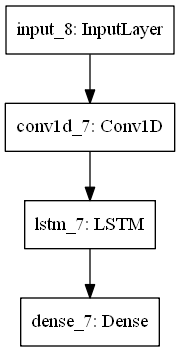

In [40]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [26]:
# Save model

# Change model number
model.save("C:\\Users\\Chanakya\\BDR 2022\\Saved_Models\\Model_1")

INFO:tensorflow:Assets written to: C:\Users\Chanakya\BDR 2022\Saved_Models\Model_1\assets


INFO:tensorflow:Assets written to: C:\Users\Chanakya\BDR 2022\Saved_Models\Model_1\assets
